# 0. Importing the Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1. Getting Tickers and Tweets

In [2]:
files = []
for file in os.listdir('data'):
    if file.endswith('.csv'):
        files.append(os.path.join('data', file))

In [3]:
data = []

for filename in files:
    with open(filename, 'r') as file:
        ticker = filename.split('_')[-1][:-4]
        line = file.readline()
        line = file.readline()
        while(line):
            ts =line.split(';"')[0][1:].split(';')[0]
            tweet = line.split(';"')[1].split('";')[0]
            line=file.readline()
            data.append([ticker,ts,tweet])
        
df = pd.DataFrame(data, columns=['ticker','timestamp','tweet'])
#df

In [4]:
df['timestamp'] = pd.to_datetime(df['timestamp'], infer_datetime_format=True)

In [5]:
df['date'] = df['timestamp'].map(lambda x:x.date())

In [6]:
df = df[df['date'] >= pd.to_datetime('2019-03-04').date()]

In [7]:
df.head()

ticker           timestamp  \
0   INTC 2019-03-21 23:29:00   
1   INTC 2019-03-21 23:25:00   
2   INTC 2019-03-21 23:25:00   
3   INTC 2019-03-21 23:25:00   
4   INTC 2019-03-21 23:24:00   

                                               tweet        date  
0  $ AAPL $ TRV $ MSFT $ HD $ DWDP $ INTC $ NKE $...  2019-03-21  
1  $ INTC Intel - Q3 2019 Intel Corporation Earni...  2019-03-21  
2  $ INTC # Intel # Intelligence # ImplementingCl...  2019-03-21  
3  $ INTC Intel - Q2 2019 Intel Corporation Earni...  2019-03-21  
4  $ INTC Intel - Q1 2019 Intel Corporation Earni...  2019-03-21

# 2. Adding Sentiment Score to Each Tweet

In [8]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [9]:
analyzer = SentimentIntensityAnalyzer()
df['compound'] = df['tweet'].map(lambda x: list(analyzer.polarity_scores(x).values())[3])

In [10]:
df['day_name'] = df['timestamp'].map(lambda x: x.day_name())
df['day'] = df['timestamp'].map(lambda x: x.day)
df['day_of_week'] = df['timestamp'].map(lambda x: x.dayofweek)

In [11]:
#df.to_csv('tweets_with_sentiment.csv')

In [12]:
df.head(5)

ticker           timestamp  \
0   INTC 2019-03-21 23:29:00   
1   INTC 2019-03-21 23:25:00   
2   INTC 2019-03-21 23:25:00   
3   INTC 2019-03-21 23:25:00   
4   INTC 2019-03-21 23:24:00   

                                               tweet        date  compound  \
0  $ AAPL $ TRV $ MSFT $ HD $ DWDP $ INTC $ NKE $...  2019-03-21    0.3680   
1  $ INTC Intel - Q3 2019 Intel Corporation Earni...  2019-03-21    0.0000   
2  $ INTC # Intel # Intelligence # ImplementingCl...  2019-03-21    0.4767   
3  $ INTC Intel - Q2 2019 Intel Corporation Earni...  2019-03-21    0.0000   
4  $ INTC Intel - Q1 2019 Intel Corporation Earni...  2019-03-21    0.0000   

   day_name  day  day_of_week  
0  Thursday   21            3  
1  Thursday   21            3  
2  Thursday   21            3  
3  Thursday   21            3  
4  Thursday   21            3

## 2.1 Data Exploration with Aggregate Sentiment

In [13]:
# get counts of positive and negative tweets
def count_sentiments(sentiment):

    if sentiment >= 0.05:
        return 1
    elif (sentiment > -0.05) and (sentiment < 0.05):
        return 0
    else:
        return -1

In [14]:
# new column to determine if tweet is positive or negative
df['pos/neg'] = df['compound'].map(count_sentiments)

In [15]:
# new dataframe to count sentiment tweets per day
sentiment_counts = pd.DataFrame(df.groupby(['date', 'pos/neg'])['tweet'].agg('count'))

In [16]:
df.head()

ticker           timestamp  \
0   INTC 2019-03-21 23:29:00   
1   INTC 2019-03-21 23:25:00   
2   INTC 2019-03-21 23:25:00   
3   INTC 2019-03-21 23:25:00   
4   INTC 2019-03-21 23:24:00   

                                               tweet        date  compound  \
0  $ AAPL $ TRV $ MSFT $ HD $ DWDP $ INTC $ NKE $...  2019-03-21    0.3680   
1  $ INTC Intel - Q3 2019 Intel Corporation Earni...  2019-03-21    0.0000   
2  $ INTC # Intel # Intelligence # ImplementingCl...  2019-03-21    0.4767   
3  $ INTC Intel - Q2 2019 Intel Corporation Earni...  2019-03-21    0.0000   
4  $ INTC Intel - Q1 2019 Intel Corporation Earni...  2019-03-21    0.0000   

   day_name  day  day_of_week  pos/neg  
0  Thursday   21            3        1  
1  Thursday   21            3        0  
2  Thursday   21            3        1  
3  Thursday   21            3        0  
4  Thursday   21            3        0

In [17]:
sent_agg_by_day = pd.DataFrame(df.groupby('date')['compound'].agg('count'))

In [18]:
sent_agg_by_day.head()

compound
date                
2019-03-04      7897
2019-03-05      7076
2019-03-06      8443
2019-03-07      8514
2019-03-08      8813

In [19]:
sentiment_counts.head()

tweet
date       pos/neg       
2019-03-04 -1        1276
            0        2914
            1        3707
2019-03-05 -1        1140
            0        2540

In [20]:
# merging datasets to get counts of positive, negative and neutral tweets daily
merged_dataset = sentiment_counts.merge(sent_agg_by_day, left_index=True, right_index=True)

In [21]:
merged_dataset = merged_dataset.reset_index()

In [22]:
merged_dataset.head()

date  pos/neg  tweet  compound
0  2019-03-04       -1   1276      7897
1  2019-03-04        0   2914      7897
2  2019-03-04        1   3707      7897
3  2019-03-05       -1   1140      7076
4  2019-03-05        0   2540      7076

In [23]:
#merged_dataset = merged_dataset.unstack()
merged_dataset = merged_dataset.pivot_table(index='date', values='tweet', columns='pos/neg')

In [24]:
merged_dataset.rename(columns={-1: 'neg', 0:'neutral', 1:'pos'}, inplace=True)

In [25]:
merged_dataset.head()

pos/neg      neg  neutral   pos
date                           
2019-03-04  1276     2914  3707
2019-03-05  1140     2540  3396
2019-03-06  1386     2931  4126
2019-03-07  1408     2798  4308
2019-03-08  1388     2630  4795

In [26]:
merged_dataset['abs_sentiment'] = merged_dataset['pos']-merged_dataset['neg']
merged_dataset['rel_sentiment'] = (merged_dataset['pos']-merged_dataset['neg'])/(merged_dataset['pos']+merged_dataset['neg'])

In [27]:
merged_dataset.head()

pos/neg      neg  neutral   pos  abs_sentiment  rel_sentiment
date                                                         
2019-03-04  1276     2914  3707           2431       0.487859
2019-03-05  1140     2540  3396           2256       0.497354
2019-03-06  1386     2931  4126           2740       0.497097
2019-03-07  1408     2798  4308           2900       0.507348
2019-03-08  1388     2630  4795           3407       0.551027

In [28]:
avg_sent_by_day = df.groupby('date')['compound'].agg('mean')

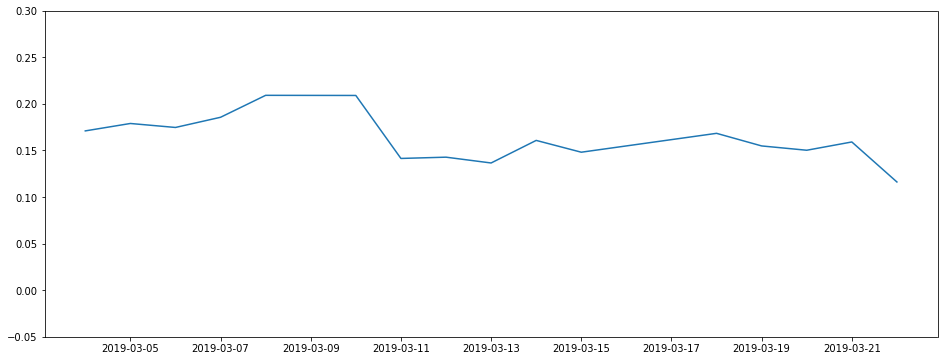

In [29]:
plt.figure(figsize=(16,6))
plt.ylim(-0.05,0.3)
plt.plot(avg_sent_by_day);

# 3. Getting Stock Data

## 3.1 Aggregate Stock Data (S&P500 Top 50)

In [30]:
# data for complete S&P500 index (gathered for analysis)
agg_sp500 = pd.read_csv('^GSPC.csv')

In [31]:
agg_sp500.set_index('Date', inplace=True)

In [32]:
agg_sp500.head()

Open         High          Low        Close    Adj Close  \
Date                                                                          
2018-12-28  2498.770020  2520.270020  2472.889893  2485.739990  2485.739990   
2018-12-31  2498.939941  2509.239990  2482.820068  2506.850098  2506.850098   
2019-01-02  2476.959961  2519.489990  2467.469971  2510.030029  2510.030029   
2019-01-03  2491.919922  2493.139893  2443.959961  2447.889893  2447.889893   
2019-01-04  2474.330078  2538.070068  2474.330078  2531.939941  2531.939941   

                Volume  
Date                    
2018-12-28  3702620000  
2018-12-31  3442870000  
2019-01-02  3733160000  
2019-01-03  3822860000  
2019-01-04  4213410000

In [33]:
agg_sp50 = pd.read_excel('S&PTop50 Aggregate Data.xls')

In [34]:
agg_sp50.rename(columns={'Effective date ':'date'}, inplace=True)

In [35]:
agg_sp50.set_index('date', inplace=True)

In [36]:
agg_sp50 = pd.DataFrame(agg_sp50['S&P 500 Top 50'])

In [37]:
agg_sp50.head()

S&P 500 Top 50
date                      
2019-03-01         2211.81
2019-03-04         2208.68
2019-03-05         2210.25
2019-03-06         2199.74
2019-03-07         2180.94

## 3.2 Causality Analysis

In [38]:
df_for_causality = merged_dataset.merge(agg_sp50, left_index=True, right_index=True)

In [39]:
df_for_causality

neg  neutral   pos  abs_sentiment  rel_sentiment  S&P 500 Top 50
date                                                                         
2019-03-04  1276     2914  3707           2431       0.487859         2208.68
2019-03-05  1140     2540  3396           2256       0.497354         2210.25
2019-03-06  1386     2931  4126           2740       0.497097         2199.74
2019-03-07  1408     2798  4308           2900       0.507348         2180.94
2019-03-08  1388     2630  4795           3407       0.551027         2177.70
2019-03-11  1993     3610  4634           2641       0.398521         2214.70
2019-03-12  2091     4108  4991           2900       0.409489         2221.30
2019-03-13  2241     4366  5203           2962       0.397904         2235.87
2019-03-14  2169     4315  5666           3497       0.446331         2234.24
2019-03-15  2600     5328  6457           3857       0.425858         2246.94
2019-03-18  1644     3922  4619           2975       0.475012         2255.37
2019-03-19  1499     4168  4101           2602       0.464643         2257.21
2019-03-20  1653     3853  4165           2512       0.431763         2257.56
2019-03-21  1570     4410  4432           2862       0.476841         2282.01
2019-03-22  1916     3962  3686           1770       0.315959         2239.18

#### Check if time series are stationary

We test if our time series are stationary. For this purpose we utilise the ADF test, applied to a single series at a time. We utilised the python implementation available via statsmodel.

In [40]:
# ADF (Augmented Dickey Fuller) Test
#define function for ADF test
from statsmodels.tsa.stattools import adfuller
def adf_test(timeseries):
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [41]:
adf_test(df_for_causality['S&P 500 Top 50'])

Results of Dickey-Fuller Test:
Test Statistic                 -1.812719
p-value                         0.374166
#Lags Used                      4.000000
Number of Observations Used    10.000000
Critical Value (1%)            -4.331573
Critical Value (5%)            -3.232950
Critical Value (10%)           -2.748700
dtype: float64


In [48]:
adf_test(df_for_causality['rel_sentiment'])

Results of Dickey-Fuller Test:
Test Statistic                -6.169997e+00
p-value                        6.841953e-08
#Lags Used                     5.000000e+00
Number of Observations Used    9.000000e+00
Critical Value (1%)           -4.473135e+00
Critical Value (5%)           -3.289881e+00
Critical Value (10%)          -2.772382e+00
dtype: float64


In [54]:
adf_test(df_for_causality['pos'])

Results of Dickey-Fuller Test:
Test Statistic                -1.197351
p-value                        0.674734
#Lags Used                     5.000000
Number of Observations Used    9.000000
Critical Value (1%)           -4.473135
Critical Value (5%)           -3.289881
Critical Value (10%)          -2.772382
dtype: float64


In [62]:
# we remove the variable that is causing collinearity
# we use only rel_sentiment
temp_df = df_for_causality[['S&P 500 Top 50', 'abs_sentiment']]

In [58]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen
coint_johansen(temp_df,-1,1).eig

array([0.5934191 , 0.05294674])

#### Granger-Causality of Stock Price with different sentiment variables

In [59]:
from statsmodels.tsa.stattools import grangercausalitytests

In [46]:
granger_test_result = grangercausalitytests(
    df_for_causality[['S&P 500 Top 50','rel_sentiment']].values,maxlag=1)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8307  , p=0.3816  , df_denom=11, df_num=1
ssr based chi2 test:   chi2=1.0573  , p=0.3038  , df=1
likelihood ratio test: chi2=1.0193  , p=0.3127  , df=1
parameter F test:         F=0.8307  , p=0.3816  , df_denom=11, df_num=1


In [47]:
granger_test_result = grangercausalitytests(
    df_for_causality[['S&P 500 Top 50','abs_sentiment']].values,maxlag=1)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.4460  , p=0.2544  , df_denom=11, df_num=1
ssr based chi2 test:   chi2=1.8404  , p=0.1749  , df=1
likelihood ratio test: chi2=1.7290  , p=0.1885  , df=1
parameter F test:         F=1.4460  , p=0.2544  , df_denom=11, df_num=1


#### Vector Autoregressive (VAR) model for Multivariate Timeseries

In [63]:
from statsmodels.tsa.vector_ar.var_model import VAR

model = VAR(endog=temp_df)
model_fit = model.fit()

/home/s_hamdani/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  % freq, ValueWarning)


In [64]:
model_fit.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 30, Mar, 2019
Time:                     10:45:37
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    18.8206
Nobs:                     14.0000    HQIC:                   18.5214
Log likelihood:          -163.557    FPE:                1.14976e+08
AIC:                      18.5467    Det(Omega_mle):     7.79765e+07
--------------------------------------------------------------------
Results for equation S&P 500 Top 50
                       coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------
const                   425.441970       369.763681            1.151           0.250
L1.S&P 500 Top 50         0.791816         0.165748            4.777           0.000
L1.abs_sentiment          0.013961 

## 3.3 Individual Stock Data (S&P500 Top 50)

In [70]:
len(df['ticker'].unique())

49

In [71]:
tickers = list(set(df['ticker'].unique()))

In [72]:
tickers.append('BRK-B')
tickers.remove('BRK')

In [73]:
len(tickers)

49

In [82]:
# import fix_yahoo_finance as yf

# complete_panel_data = yf.download(tickers, start="2019-03-01", end="2019-03-27")

In [77]:
import pandas_datareader

start_date = '2019-03-01'
end_date = '2019-03-28'

complete_panel_data = pandas_datareader.get_data_yahoo(tickers, start_date, end_date)

In [80]:
complete_panel_data.head()

Attributes        High                                                \
Symbols           AAPL       ABBV        ABT        ADBE        AMGN   
Date                                                                   
2019-03-01  175.149994  80.849998  78.739998  266.239990  192.059998   
2019-03-04  177.750000  80.730003  78.970001  267.000000  192.119995   
2019-03-05  176.000000  79.900002  78.910004  259.869995  190.669998   
2019-03-06  175.490005  79.129997  78.220001  259.489990  189.369995   
2019-03-07  174.440002  79.120003  77.949997  257.489990  183.160004   

Attributes                                                              \
Symbols            AMZN        AVGO          BA        BAC       BRK-B   
Date                                                                     
2019-03-01  1674.260010  278.160004  446.010010  29.650000  203.839996   
2019-03-04  1709.430054  276.579987  444.500000  29.540001  204.869995   
2019-03-05  1707.800049  280.440002  433.850006  29.190001  202.000000   
2019-03-06  1697.750000  276.929993  432.000000  29.160000  202.300003   
2019-03-07  1669.750000  270.329987  434.350006  28.719999  200.580002   

Attributes    ...      Adj Close                                    \
Symbols       ...             PM       PYPL          T         UNH   
Date          ...                                                    
2019-03-01    ...      86.415771  98.800003  30.820000  245.214050   
2019-03-04    ...      86.188644  96.570000  29.980000  235.122589   
2019-03-05    ...      85.892395  96.529999  29.950001  240.512009   
2019-03-06    ...      85.931892  96.459999  29.809999  238.160995   
2019-03-07    ...      85.882523  96.209999  29.920000  235.799988   

Attributes                                                                      
Symbols            UNP           V         VZ        WFC        WMT        XOM  
Date                                                                            
2019-03-01  167.440002  149.470001  56.959999  50.029999  97.405891  80.000000  
2019-03-04  167.369995  147.960007  56.240002  50.110001  97.326317  80.309998  
2019-03-05  166.779999  147.949997  56.080002  49.889999  97.813690  80.190002  
2019-03-06  165.910004  147.809998  55.680000  49.820000  97.734123  79.279999  
2019-03-07  164.940002  146.830002  56.299999  49.680000  96.928452  80.160004  

[5 rows x 294 columns]

In [38]:
complete_panel_data.loc[complete_panel_data.index]['Adj Close']

AAPL       ABBV        ABT        ADBE        AMGN  \
Date                                                                   
2019-03-01  174.970001  80.099998  78.589996  264.010010  191.160004   
2019-03-04  175.850006  79.459999  78.620003  258.160004  189.779999   
2019-03-05  175.529999  78.910004  78.220001  257.380005  188.820007   
2019-03-06  174.520004  78.089996  77.699997  256.399994  183.149994   
2019-03-07  172.500000  78.239998  76.800003  255.460007  181.460007   
2019-03-08  172.910004  77.580002  76.629997  254.740005  180.869995   
2019-03-11  178.899994  78.080002  77.809998  260.959991  184.139999   
2019-03-12  180.910004  78.739998  78.239998  263.510010  184.179993   
2019-03-13  181.710007  78.930000  78.620003  264.380005  187.350006   
2019-03-14  183.729996  79.949997  78.980003  267.690002  187.759995   
2019-03-15  186.119995  81.339996  79.860001  257.089996  191.240005   
2019-03-18  188.020004  80.650002  78.830002  257.760010  191.309998   
2019-03-19  186.529999  80.820000  79.959999  260.420013  191.490005   
2019-03-20  188.160004  80.430000  79.940002  259.739990  191.119995   
2019-03-21  195.089996  81.239998  80.059998  264.179993  191.889999   
2019-03-22  191.050003  79.760002  77.970001  259.690002  186.699997   
2019-03-25  188.740005  79.510002  78.230003  262.269989  186.589996   
2019-03-26  186.789993  80.760002  79.000000  265.589996  188.270004   
2019-03-27  187.985001  80.129997  78.410004  261.299988  186.250000   

                   AMZN        AVGO          BA        BAC       BRK-B  \
Date                                                                     
2019-03-01  1671.729980  270.335175  440.619995  29.309999  203.130005   
2019-03-04  1696.170044  272.456238  432.690002  29.030001  201.809998   
2019-03-05  1692.430054  274.557465  430.119995  29.080000  201.470001   
2019-03-06  1668.949951  268.947571  424.459991  28.840000  200.669998   
2019-03-07  1625.949951  263.159271  422.559998  28.549999  199.300003   
2019-03-08  1620.800049  261.850952  422.540009  28.650000  198.699997   
2019-03-11  1670.619995  266.677826  400.010010  28.940001  202.089996   
2019-03-12  1673.099976  267.242798  375.410004  28.940001  202.500000   
2019-03-13  1690.810059  268.808777  377.140015  29.290001  204.059998   
2019-03-14  1686.219971  265.825470  373.299988  29.459999  203.380005   
2019-03-15  1712.359985  287.719879  378.989990  29.299999  204.309998   
2019-03-18  1742.150024  291.238434  372.279999  29.820000  206.679993   
2019-03-19  1761.849976  296.660004  373.429993  29.650000  205.149994   
2019-03-20  1797.270020  291.029999  376.160004  28.639999  203.270004   
2019-03-21  1819.260010  296.799988  372.700012  28.180000  204.429993   
2019-03-22  1764.770020  292.649994  362.170013  27.010000  200.550003   
2019-03-25  1774.260010  292.160004  370.459991  26.840000  199.440002   
2019-03-26  1783.760010  297.029999  370.380005  27.209999  200.619995   
2019-03-27  1759.194946  293.239990  368.130005  27.110001  198.970001   

              ...             PM        PYPL          T         UNH  \
Date          ...                                                     
2019-03-01    ...      86.415771   98.800003  30.820000  245.214050   
2019-03-04    ...      86.188644   96.570000  29.980000  235.122589   
2019-03-05    ...      85.892395   96.529999  29.950001  240.512009   
2019-03-06    ...      85.931892   96.459999  29.809999  238.160995   
2019-03-07    ...      85.882523   96.209999  29.920000  235.799988   
2019-03-08    ...      86.356514   95.690002  29.959999  237.289993   
2019-03-11    ...      88.124130   97.449997  30.219999  243.149994   
2019-03-12    ...      87.689636   97.500000  30.629999  245.880005   
2019-03-13    ...      88.380882   99.309998  30.280001  252.250000   
2019-03-14    ...      88.667259   99.029999  30.280001  253.270004   
2019-03-15    ...      89.714005  100.730003  30.670000  251.399994   
2019-03-18    ...      89.5

In [79]:
#complete_panel_data.to_csv('panel_data')